In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mlscorecheck.auc import (
    auc_min, 
    auc_max, 
    auc_rmin, 
    auc_maxa, 
    auc_rmin,
    auc_estimator,
    max_acc_estimator,
    macc_min,
    acc_max)

In [2]:
input_label = 'aggregated'

input_file = f'fit-{input_label}-50k.csv'
output_file = f'processed-{input_label}-50k-clipped.csv'

In [3]:
data = pd.read_csv(input_file)
data[['exp_tpr', 'exp_fpr']].median()

exp_tpr    1.685052
exp_fpr    0.634456
dtype: float64

In [5]:
def protect(function, args):
    try:
        return function(*args)
    except:
        return None

In [6]:
data['auc_min'] = data.apply(lambda row: auc_min(1 - row['spec'], row['sens']), axis=1)
data['auc_min_best'] = data.apply(lambda row: auc_min(1 - row['best_spec'], row['best_sens']), axis=1)
data['auc_max'] = data.apply(lambda row: auc_max(1 - row['spec'], row['sens']), axis=1)
data['auc_max_best'] = data.apply(lambda row: auc_max(1 - row['best_spec'], row['best_sens']), axis=1)
data['auc_maxa_best'] = data.apply(lambda row: protect(auc_maxa, (row['best_acc'], row['p'], row['n'])), axis=1)
data['auc_rmin'] = data.apply(lambda row: protect(auc_rmin, (1 - row['spec'], row['sens'])), axis=1)
data['auc_rmin_best'] = data.apply(lambda row: protect(auc_rmin, (1 - row['best_spec'], row['best_sens'])), axis=1)

In [7]:
def estimate(label0, label1, mode='normal', weighted=False):
    if mode != 'best':
        mode = 'normal'
    if weighted:
        weighted_label = 'w'
    else:
        weighted_label = 'nw'
    if mode != 'best':
        if not weighted:
            weights0 = np.repeat(1.0, len(data))
            weights1 = np.repeat(1.0, len(data))
        else:
            weights0 = data[f'err_{label1}']
            weights1 = data[f'err_{label0}']

        weights0, weights1 = weights0 / (weights0 + weights1), weights1 / (weights0 + weights1)
        data[f'auc_{label0}_{label1}_{mode}_{weighted_label}'] = weights0*data[f'auc_{label0}'] + weights1*data[f'auc_{label1}']
    else:
        if not weighted:
            weights0 = np.repeat(1.0, len(data))
            weights1 = np.repeat(1.0, len(data))
        else:
            weights0 = data[f'err_{label1}_best']
            weights1 = data[f'err_{label0}_best']

        weights0, weights1 = weights0 / (weights0 + weights1), weights1 / (weights0 + weights1)
        data[f'auc_{label0}_{label1}_{mode}_{weighted_label}'] = weights0*data[f'auc_{label0}_best'] + weights1*data[f'auc_{label1}_best']

In [8]:
estimate('min', 'max', 'normal', False)
estimate('min', 'max', 'best', False)
estimate('rmin', 'max', 'normal', False)
estimate('rmin', 'max', 'best', False)
estimate('min', 'maxa', 'best', False)
estimate('rmin', 'maxa', 'best', False)

In [9]:
(auc_estimator(0.024, 0.776, 30000, 300000, mode='separate', best=True),
auc_estimator(0.024, 0.776, 30000, 300000, mode='joint', best=True),
auc_estimator(0.024, 0.776, 30000, 300000, mode='roc', best=True))

((0.9741123400395921,
  np.float64(0.7243191458012499),
  np.float64(4.26889190155123)),
 (0.9658991740311904,
  np.float64(0.7939617845382275),
  np.float64(4.278214201767616)),
 (0.9718685824057304,
  np.float64(7.201595336442369),
  np.float64(7.201595336442369)))

In [10]:
data[['auc_integral_joint_best', 'aijb_p_fpr', 'aijb_p_tpr']] = \
    data.apply(lambda row: auc_estimator(1.0 - row['best_spec'], row['best_sens'], row['p'], row['n'], mode='joint', best=True), 
               axis=1, result_type="expand")

In [11]:
data[['auc_integral_roc', 'air_p_fpr', 'air_p_tpr']] = \
    data.apply(lambda row: auc_estimator(1.0 - row['spec'], row['sens'], row['p'], row['n'], mode='roc', best=False), 
               axis=1, result_type="expand")
data[['auc_integral_roc_best', 'airb_p_fpr', 'airb_p_tpr']] = \
    data.apply(lambda row: auc_estimator(1.0 - row['best_spec'], row['best_sens'], row['p'], row['n'], mode='roc', best=True), 
               axis=1, result_type="expand")

In [12]:
#data['auc_integral_roc_rast'] = data.apply(lambda row: auc_estimator(1.0 - row['spec'], row['sens'], row['p'], row['n'], mode='roc', best=False, rasterize=True), axis=1)
#data['auc_integral_roc_best_rast'] = data.apply(lambda row: auc_estimator(1.0 - row['best_spec'], row['best_sens'], row['p'], row['n'], mode='roc', best=True, rasterize=True), axis=1)

In [13]:
data['max_acc_integral'] = data.apply(lambda row: max_acc_estimator(row['auc'], row['p'], row['n']), axis=1)

In [14]:
data['max_acc_min'] = data.apply(lambda row: macc_min(row['auc'], row['p'], row['n']), axis=1)
data['max_acc_max'] = data.apply(lambda row: acc_max(row['auc'], row['p'], row['n']), axis=1)

In [15]:
data.to_csv(output_file, index=False)

In [16]:
from sklearn.metrics import r2_score

In [17]:
r2_score(data['auc'], data['auc_integral_joint_best'])

0.8631458670203263

In [18]:
#data_tmp = data[data['p_train'] + data['n_train'] > 1000]

In [19]:
#r2_score(data_tmp['auc'], data_tmp['auc_integral_joint_best']), r2_score(data_tmp['auc'], data_tmp['auc_integral_joint_best_rast'])

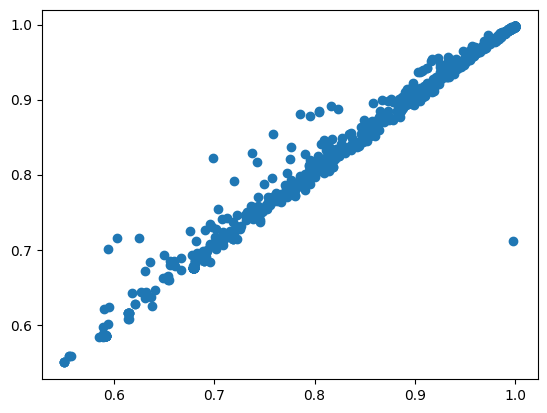

In [20]:
plt.scatter(data['auc_integral_joint_best'], data['auc_integral_roc_best'])

In [21]:
r2_score(data['auc'], data['auc_integral_roc_best']), r2_score(data['auc'], data['auc_integral_joint_best'])

(0.8551631085580392, 0.8631458670203263)

In [22]:
plt.scatter(data['auc'], data['auc_integral_sep_best'])
plt.scatter(data['auc'], data['auc_integral_joint_best'])

KeyError: 'auc_integral_sep_best'